# Book Success Prediction using Machine Learning

Kathryn Hamilton and Frank Shannon

w207 Spring 2018

### Introduction

The team would like to assess the relationship between the synopsis of a novel and its success by constructing a supervised machine learning classifier.

A book's synopsis, which is a couple paragraphs traditionally found on the back or inside cover of a book, serves to provide a brief explanation of the book's contents and any applicable critical acclaim of the the author. The team would like to see if this information can be used to reliably predict whether or not the book will be successful. To do this, the team will study harness information found on Amazon.com, one of the world's largest e-commerce and cloud computing companies which, fittingly, started as an online bookstore.

We begin by importing the necessary libraries and setting up our document.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import gzip
import re
import copy

The data we will be using for this project come from two sources.

The first is an online repository of `.json` files compiled by Julian McAuley, Assistant Professor of Computer Science and Engineering at University of California, San Diego. These files, which can be found at http://jmcauley.ucsd.edu/data/amazon/ and will provides us with customer review information and product metadata [1, 2].

The second will be an API the team uses to scrape book synopsis data from http://www.amazon.com/ using the list of product ID numbers included in the dataset of reviews.

Prof. McAuley's papers related to the Amazon dataset are as follows:

[1] R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016

[2] J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

### Import and Clean Data

We first explore the datasets provided by McAuley. These files are very large so we are looking to get rid of any information that will not be useful to us.

In addition, we will want to narrow down the data into a subset that seems well suited for the purpose of this project. For starters, this means selecting a category of books (Fiction, Travel, Money & Business, etc) that has enough examples and a good range of descriptive synopses.

At this point in the project our inputs and outputs are very loosely defined. It is hard to know specifically what we data will need in the end and if we even have it to begin with. So, some upfront exploration is a good first approach to begin forming a problem that we can reasonably solve.

In [2]:
# Unpackage McAuley metadata and reviews files, which are currently compressed .json files, using the code supplied on his site.

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0 
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

metadata_import = getDF('meta_Books.json.gz')
#reviews_import = getDF('reviews_Books.json.gz')

Let's take a look at the first few rows of each file.

In [3]:
print "Length: ", len(metadata_import)   # print length of dataframe
metadata_import.head(n=5)   # print first 5 rows of dataframe

Length:  2370585


,asin,salesRank,imUrl,categories,title,description,related,price,brand
0,0001048791,{u'Books': 6334800},http://ecx.images-amazon.com/images/I/51MKP0T4...,[[Books]],"The Crucible: Performed by Stuart Pankin, Jero...",NaN,NaN,NaN,NaN
1,0001048775,{u'Books': 13243226},http://ecx.images-amazon.com/images/I/5166EBHD...,[[Books]],Measure for Measure: Complete &amp; Unabridged,William Shakespeare is widely regarded as the ...,NaN,NaN,NaN
2,0001048236,{u'Books': 8973864},http://ecx.images-amazon.com/images/I/51DH145C...,[[Books]],The Sherlock Holmes Audio Collection,"&#34;One thing is certain, Sherlockians, put a...","{u'also_viewed': [u'1442300191', u'9626349786'...",9.26,NaN
3,0000401048,{u'Books': 6448843},http://ecx.images-amazon.com/images/I/41bchvIf...,[[Books]],The rogue of publishers' row;: Confessions of ...,NaN,{u'also_viewed': [u'068240103X']},NaN,NaN
4,0001019880,{u'Books': 9589258},http://ecx.images-amazon.com/images/I/61LcHUdv...,[[Books]],Classic Soul Winner's New Testament Bible,NaN,"{u'also_viewed': [u'B003HMB5FC', u'0834004593'...",5.39,NaN


In [76]:
#print "Length: ", reviews_import.size   # print length of dataframe
#reviews_import.head(n=5)   # print first 5 rows of dataframe

Let's start with the `metadata` file, which describes each book.

Immediately, we see that there are several columns that will likely be of use to us:

* `asin`, which is the unique product identification number used by Amazon.
* `salesRank`, which describes the popularity of the book within the Amazon category "Books".
* `categories`, which describes the category and sub category that the book is classified as.

There are also several columns that are not of use to us:

* `imUrl`, which is a link to the product's photo.
* `related`, which is a list of similar products.
* `brand`, which might describe affiliate companies such as the book's publisher

The first thing to do is process these fields to be the correct data type and organize the information to be suited to our project.

In [4]:
metadata = metadata_import.copy()   # create a duplicate data frame of the imported file

# convert column headers from unicode to ascii
metadata = metadata.rename(index=str,columns={u'asin':'asin', u'salesRank':'salesRank', u'imUrl':'imUrl', 
                                              u'categories':'categories', u'title':'title', u'description':'description',
                                              u'related':'related', u'price':'price', u'brand':'brand'})

metadata = metadata.drop(['imUrl','related','brand'],axis=1)   # drop unrelated columns

print "Length: ", len(metadata)   # print length of dataframe

Length:  2370585


Let's fix the syntax of the `salesRank` column so it displays as simple integer. We will set the rank to 0 for any entry that is NaN-valued, or has a ranking in a cartegory other than "Books".

In [5]:
metadata['salesRank'][metadata['salesRank'].isnull()] = 0
metadata['salesRank'] = metadata['salesRank'].astype(str)
metadata['salesRank'][~metadata['salesRank'].str.contains('Books')] = 0

metadata['salesRank'] = metadata['salesRank'].astype(str)
metadata['salesRank'] = metadata['salesRank'].str.lstrip("{'Books': ")   # strip json/unicode characters from left
metadata['salesRank'] = metadata['salesRank'].str.rstrip("}")   # strip json/unicode characters from right
metadata['salesRank'] = metadata['salesRank'].astype('int64')   # set column to be integer type

C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Let's take a quick look at the distribution of `salesRank`. Remember that zero-valued rankings are equivalent to `NA`.

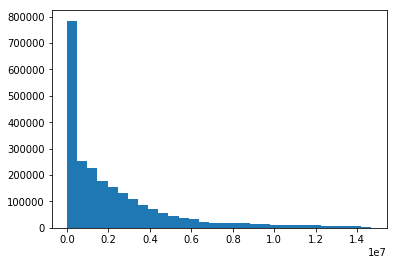

In [13]:
plt.hist(metadata['salesRank'][metadata['salesRank']!=0], bins=30)
plt.show()

While we're at it, let's also take a look at the distribution of `price`. We see that it is roughly normal with a heavy right-skew.

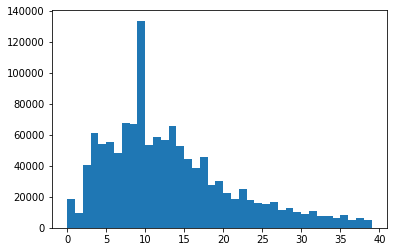

In [113]:
plt.hist(metadata['price'].dropna(axis=0), bins = range(0,40))
plt.show()

We have over two million titles to work with, which is great. Ideally we would like to narrow this down to a more workable size, likely by choosing a certain category or genre of books.

Let's check to see how many books fall into each category.

In [14]:
# convert to string and then group, sort and display
metadata['categories'] = metadata['categories'].astype(str)
metadata.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
[['Books']],1940253
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica']]",8113
"[['Books', 'Literature & Fiction'], ['Books', 'Romance', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Romance', 'Contemporary']]",4060
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica', 'Romantic Erotica']]",3189
"[['Books', 'Literature & Fiction', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Contemporary Fiction']]",3154
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica', 'BDSM']]",3096
"[['Books', 'Reference', 'Words, Language & Grammar', 'Linguistics'], ['Kindle Store', 'Kindle eBooks', 'Reference', 'Words, Language & Grammar', 'Linguistics']]",1692
"[['Books', 'Literature & Fiction'], ['Books', 'Romance'], ['Kindle Store', 'Kindle eBooks', 'Romance']]",1599
"[['Books', 'Literature & Fiction'], ['Books', 'Romance', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Contemporary Fiction', 'Romance'], ['Kindle Store', 'Kindle eBooks', 'Romance', 'Contemporary']]",1550


The above a table of unique categories listed in descending number of books per category. We see that 1.9 million entries are uncategorized (their category is simply `Books`). However, this still leaves about 0.5 million books that have been categorized.

We see that there is an issue here with overcategorization. For example, we see that there are several of the above rows that fall under `Literature & Fiction` but have been specified further such that in their current format these entries are not bucketed together. 

The next logical step is to roll back these classifications to a higher level (for example, change `['Books', 'Literature & Fiction', 'Contemporary']` into simply `Literature & Fiction`), and then regroup the data.

In [16]:
metadata['categories'] = metadata['categories'].astype(str)
orig_categs = metadata.categories.values   # Get a list of all categories
orig_categs = np.unique(orig_categs)   # Cut this down to only the unique categories

new_categs = copy.copy(orig_categs)   # Create a copy of this list

for i in range(0,len(new_categs)):   # For each unique category
    text = re.sub('[^a-zA-Z&, ]+', '', str(new_categs[i]))   # Remove all the extra symbols and space
    text = text.split(",")   # Split by comma
    if len(text)>1:   # If there is more than one element (category contains a sub category)
        new_categs[i] = text[1].lstrip(' ')   # New category name is the first sub category
    else:   # If there is no sub category
        new_categs[i] = 'Books'   # New category name is simply "books"

print "New, simpler categories are: \n\n", np.unique(new_categs)   # print new categories

New, simpler categories are: 

['Arts & Photography' 'Biographies & Memoirs' 'Books' 'Business & Money'
 'Calendars' 'Childrens Books' 'Christian Books & Bibles'
 'Comics & Graphic Novels' 'Computers & Technology' 'Cookbooks' 'Crafts'
 'Crafts & Sewing' 'Diapering' 'Education & Teaching'
 'Engineering & Transportation' 'Exterior Accessories' 'Gay & Lesbian'
 'Health' 'Health & Baby Care' 'History' 'Humor & Entertainment' 'Law'
 'Literature & Fiction' 'Medical Books' 'Mystery' 'New'
 'Parenting & Relationships' 'Politics & Social Sciences' 'Reference'
 'Religion & Spirituality' 'Romance' 'Science & Math'
 'Science Fiction & Fantasy' 'SelfHelp' 'Sports & Outdoors'
 'Teen & Young Adult' 'Travel']


These categories look to be at a great level for our analysis!

Now have a way to map the original categories into the list above. Some examples of this mapping are seen below.

In [19]:
pd.DataFrame(np.column_stack((orig_categs, new_categs)), columns = ("OldLabel","NewLabel")).head(n=10)

,OldLabel,NewLabel
0,"[['Arts, Crafts & Sewing', 'Beading & Jewelry-...",Crafts & Sewing
1,"[['Arts, Crafts & Sewing', 'Beading & Jewelry-...",Crafts & Sewing
2,"[['Arts, Crafts & Sewing', 'Craft Supplies', '...",Crafts & Sewing
3,"[['Arts, Crafts & Sewing', 'Craft Supplies', '...",Crafts & Sewing
4,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
5,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
6,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
7,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
8,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
9,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing


Let's replace the categories in the dataframe according to the mapping.

In [49]:
metadata['categories'] = metadata['categories'].astype(str)   # convert categories from objects to strings
#for i in range(0,len(orig_categs)):
for i in range(0, len(orig_categs)):
    metadata['categories'] = metadata['categories'].replace(str(orig_categs[i]), str(new_categs[i]))

We've done a lot of heavy computation so let's make sure we don't lose it.

In [46]:
metadata_backup = metadata.copy()
metadata.to_pickle('metadata.pkl')
# metadata = pd.read_pickle('metadata.pkl')

Now let's take another look at how many examples we have in each category.

In [47]:
# convert to string and then group, sort and display
metadata['categories'] = metadata['categories'].astype(str)
metadata.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
Books,1940253
Literature & Fiction,200791
Childrens Books,25424
Christian Books & Bibles,22470
Business & Money,18174
Biographies & Memoirs,18145
Health,18036
Cookbooks,11678
Gay & Lesbian,11533


Amazing! Now we have plenty of examples in each category.

Unfortunately, very few examples in these categories have information in the `salesRank` field. This is something we will have to work with.

In [56]:
metadata2 = metadata[metadata['salesRank'] != 0]
metadata2.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
Books,1890996
Health,6
Sports & Outdoors,4
Crafts,2
Reference,2
Arts & Photography,1
Childrens Books,1
Computers & Technology,1
New,1


Let's look at a few rows of the dataframe to get reacquainted with where we are.

In [59]:
metadata.head(n=5)   # print first 5 rows of dataframe

,asin,salesRank,categories,title,description,price
0,0001048791,6334800,Books,"The Crucible: Performed by Stuart Pankin, Jero...",NaN,NaN
1,0001048775,13243226,Books,Measure for Measure: Complete &amp; Unabridged,William Shakespeare is widely regarded as the ...,NaN
2,0001048236,8973864,Books,The Sherlock Holmes Audio Collection,"&#34;One thing is certain, Sherlockians, put a...",9.26
3,0000401048,6448843,Books,The rogue of publishers' row;: Confessions of ...,NaN,NaN
4,0001019880,9589258,Books,Classic Soul Winner's New Testament Bible,NaN,5.39


## -----EVERYTHING IS GOOD ABOVE HERE-----

This dataset is still much to large to work with so the next thing we need to do is partition this into some workable dataframes.

To start, we select a few genres that we think are most interesting.

Next, we need three sets of data: a training set, a development set, and a test set.

Based on the number of examples in each of the selected categories, it seems reasonable to create the following sizes:

This can all be summarized by the following criteria:

* 3 categories: x, y and z
* 3 sets of data:
    * training set: 500 examples per category
    * development set: 100 examples per category
    * test set: 100 examples per category
* each set uniformly disributed across ranking
* each set uniformly distributed across price, with a maximum price of $30
   

## -----EVERYTHING BELOW HERE IS JUNK IM HESITANT TO DISCARD-----

In [ ]:
#metadata = metadata.dropna(axis=0,subset=['asin','salesRank','categories']) # drop rows with NaN in: asin, salesRank, category

#metadata['salesRank'] = metadata['salesRank'].astype(str)   # convert salesRank from objects to strings
#metadata['salesRank'] = metadata['salesRank'].str.lstrip(' ')   # drop rows that are not ranked as a book
#metadata = metadata[metadata['salesRank'].str.startswith("{'Books':")]   # drop rows that are not ranked as a book

#metadata.reset_index(drop = True, inplace = True)   # reset indexing to account for removed rows

To do this efficiently, we first pull a list of all unique categories. Then, we can process the text string of each original category to determine a new, simpler category string. Finally, we must simply loop through the dataframe and replace the original categories with their corresponding new, simpler category.

In [81]:
metadata['categories'] = metadata['categories'].astype(str)
metadata_nb = metadata[metadata['categories'].str.startswith("[['Books', '")]   # drop rows that are not ranked as a book
metadata_b = metadata[~metadata['categories'].str.startswith("[['Books', '")]

metadata_nb['categories'] = metadata['categories'].str.replace('[^a-zA-Z&, ]+', '')
print metadata_nb['categories']
metadata_nb['categories'] = metadata['categories'].astype(str).str.lstrip(" ")   # strip json/unicode characters from left
metadata_nb['categories'] = metadata['categories'].astype(str).str.replace('Books, ','')   # strip json/unicode characters from left
print metadata_nb['categories']
#metadata_nb['categories'] = metadata['categories'].str.split(",",1)   # strip json/unicode characters from right
#print metadata_nb['categories']

metadata_nb
#metadata_b['categories'] = "Books"

C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


39668      Books, Health, Fitness & Dieting, Diets & Weig...
125629     Books, Computers & Technology, Computer Scienc...
321319     Books, New, Used & Rental Textbooks, Books, Re...
572189     Books, Crafts, Hobbies & Home, Antiques & Coll...
621794     Books, Health, Fitness & Dieting, Sexual Healt...
626559                      Books, Reference, Atlases & Maps
626648         Books, Reference, Atlases & Maps, Travel Maps
626878     Books, Arts & Photography, Photography & Video...
843441     Books, Travel, United States, South, South Atl...
853929     Books, Health, Fitness & Dieting, Books, New, ...
967576       Books, Sports & Outdoors, Winter Sports, Skiing
1034767    Books, Science & Math, Biological Sciences, Pl...
1423974    Books, Sports & Outdoors, Mountaineering, Rock...
1466748    Books, Health, Fitness & Dieting, Exercise & F...
1525106    Books, Religion & Spirituality, New Age, Divin...
1551354    Books, Sports & Outdoors, Hiking & Camping, Ex...
1551372    Books, Sports

C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


39668      [['Books', 'Health, Fitness & Dieting', 'Diets...
125629     [['Books', 'Computers & Technology', 'Computer...
321319     [['Books', 'New, Used & Rental Textbooks'], ['...
572189     [['Books', 'Crafts, Hobbies & Home', 'Antiques...
621794     [['Books', 'Health, Fitness & Dieting', 'Sexua...
626559            [['Books', 'Reference', 'Atlases & Maps']]
626648     [['Books', 'Reference', 'Atlases & Maps', 'Tra...
626878     [['Books', 'Arts & Photography', 'Photography ...
843441     [['Books', 'Travel', 'United States', 'South',...
853929     [['Books', 'Health, Fitness & Dieting'], ['Boo...
967576     [['Books', 'Sports & Outdoors', 'Winter Sports...
1034767    [['Books', 'Science & Math', 'Biological Scien...
1423974    [['Books', 'Sports & Outdoors', 'Mountaineerin...
1466748    [['Books', 'Health, Fitness & Dieting', 'Exerc...
1525106    [['Books', 'Religion & Spirituality', 'New Age...
1551354    [['Books', 'Sports & Outdoors', 'Hiking & Camp...
1551372    [['Books', 'S

C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,asin,salesRank,categories,title,description,price
39668,0071436588,{'Books': 146019},"[['Books', 'Health, Fitness & Dieting', 'Diets...",Nutrition Almanac,"Take charge of your well-being, improve your h...",12.76
125629,0262693151,{'Books': 552588},"[['Books', 'Computers & Technology', 'Computer...",NaN,"""Independent component analysis is a recent an...",212.80
321319,0485175185,{'Books': 4291916},"[['Books', 'New, Used & Rental Textbooks'], ['...",NaN,Text: English,33.25
572189,0764301268,{'Books': 1533853},"[['Books', 'Crafts, Hobbies & Home', 'Antiques...",The Movado History,A lavishly illustrated history of Movado from ...,80.96
621794,0789404370,{'Books': 700648},"[['Books', 'Health, Fitness & Dieting', 'Sexua...",Pocket Kama Sutra,"An update and reinterpretation of the 2,000 ye...",10.15
626559,0792249771,{'Books': 712481},"[['Books', 'Reference', 'Atlases & Maps']]",Japan and Korea Wall Map (tubed) (Reference - ...,"Founded in 1915 as the Cartographic Group, the...",NaN
626648,0792250222,{'Books': 550185},"[['Books', 'Reference', 'Atlases & Maps', 'Tra...",Middle East [Laminated] (National Geographic: ...,Our recently updated wall map of the Middle Ea...,NaN
626878,079227363X,{'Books': 746806},"[['Books', 'Arts & Photography', 'Photography ...",NaN,"Through the years,National Geographicmagazine'...",30.00
843441,0899333184,{'Books': 515637},"[['Books', 'Travel', 'United States', 'South',...",Florida Atlas &amp; Gazetteer,The first choice of outdoors enthusiasts. Beau...,NaN
853929,0914783386,{'Books': 8513455},"[['Books', 'Health, Fitness & Dieting'], ['Boo...",NaN,NaN,34.95


In [22]:
metadata['categories'] = metadata['categories'].astype(str)   # convert categories from objects to strings

print len(metadata)

cat_index = 150

#for i in range(0,len(metadata)):
for i in range(150,len(metadata)):
    for j in range(0,len(orig_categs)):
        if metadata['categories'][i] == str(orig_categs[j]):
            metadata['categories'][i] = new_categs[j]
    cat_index = i

1891163
0


C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


100


KeyboardInterrupt: 

In [ ]:
metadata['categories'] = metadata['categories'].astype(str)
for i in range(0,10):
    categ = metadata.iloc[i]['categories']
    categ = categ[0]
    if len(categ) > 1:
        categ = categ[1]
    metadata['categories'][i] = categ

In [ ]:
metadata['categories'] = metadata['categories'].astype(str)
metadata['categories'] = metadata.categories.astype('category')
metadata.groupby(['categories']).count()